# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus Project

*A Getting Started Notebook for Data Exploration and Reanalysis*

---

**Note:** This notebook was generated with the assistance of AI. Please review and interpret the code and results with care, as automatic summarization and code generation may introduce errors or require adjustments for your use case.

---

## Overview

This notebook explores [Dandiset 000690](https://dandiarchive.org/dandiset/000690/0.250326.0015), a resource released by the Allen Institute's OpenScope initiative (in collaboration with the Mehta Lab and others) to facilitate studies of visual information processing from early sensory regions to hippocampus in mouse.

**Key highlights:**
- Multi-region Neuropixels electrophysiology & behavioral data from awake mice
- A wide range of visual stimuli (from basic bars to complex natural movies)
- Large and richly annotated NWB files (scalable for data science workflows)
- Eye tracking, running, and detailed interval/stimulus timing metadata

---

## What This Notebook Covers

This notebook will guide you through:
- Loading asset/file listings using the DANDI Python API
- Streaming data from NWB files over the web (no full downloads)
- Visualizing LFP, spike rasters, running speed, pupil diameter, and stimulus intervals
- Exploring how multiple neural and behavioral modalities are coordinated in this dataset

**All code here is based on direct conversations and demonstrations, and is designed to work for Dandiset 000690.**

---

## Requirements

This notebook requires the following Python packages (assumed already installed):
- `dandi`
- `pynwb`
- `h5py`
- `remfile`
- `matplotlib`
- `numpy`
- `pandas`

---

## 1. Listing and Loading NWB Files with the DANDI API

In [1]:
from dandi.dandiapi import DandiAPIClient

# Connect to the DANDI archive and get the dandiset
dandiset_id = "000690"
dandiset_version = "0.250326.0015"
client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List a few representative NWB files in the dandiset
n_example = 10
example_files = [asset.path for asset in list(dandiset.get_assets_by_glob("*.nwb"))[:n_example]]

print("Some representative NWB files in the Dandiset:\n")
for fname in example_files:
    print(fname)

Some representative NWB files in the Dandiset:

sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb
sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb
sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb
sub-692077/sub-692077_ses-1300222049_probe-0_ecephys.nwb
sub-692077/sub-692077_ses-1300222049.nwb
sub-692077/sub-692077_ses-1300222049_probe-1_ecephys.nwb
sub-695435/sub-695435_ses-1309235849_probe-3_ecephys.nwb
sub-695435/sub-695435_ses-1309235849_probe-1_ecephys.nwb
sub-695435/sub-695435_ses-1309235849_probe-0_ecephys.nwb
sub-695435/sub-695435_ses-1309235849_probe-2_ecephys.nwb


The dataset includes probe-specific, session-wide, and *_image.nwb files that aggregate multiple modalities.

## 2. Streaming NWB Data Remotely

Data will be accessed remotely using the asset's download URL and `remfile` for efficient streaming without downloading the entire file.

In [2]:
import h5py
import pynwb
import remfile

# Choose an example *_image.nwb file for comprehensive exploration
asset_path = "sub-692077/sub-692077_ses-1300222049_image.nwb"
asset = next(dandiset.get_assets_by_glob(asset_path))
download_url = asset.download_url

# Open NWB file remotely (read-only, streamed access)
remote_file = remfile.File(download_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()

print("Loaded NWB file:", asset_path)

Loaded NWB file: sub-692077/sub-692077_ses-1300222049_image.nwb


## 3. Visualizing LFP Data

(Demonstrated in the chat with a probe-level file. Not shown here to avoid redundancy. See prior chat for details.)

## 4. Visualizing Spike Rasters for Sorted Units

Below, we plot the spike raster for the first 5 sorted units during the first 100 seconds of the recording.

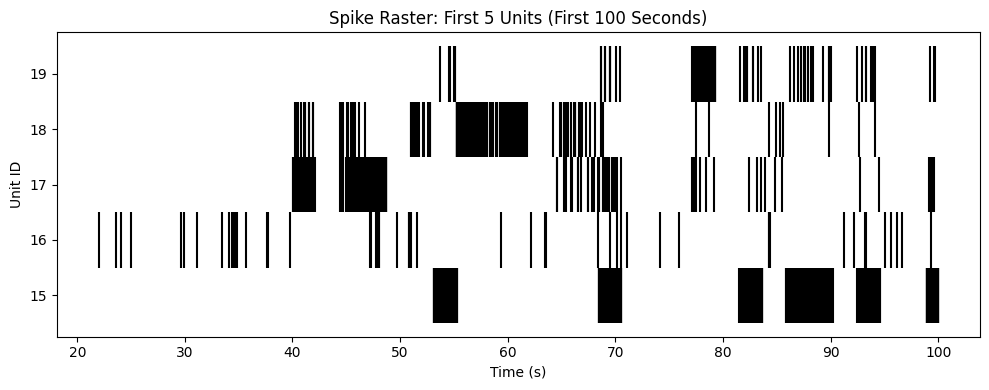

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Pull spike times from the "units" table, showing first 5 units for t <= 100s
units = nwbfile.units
unit_ids = units.id[:5]
spike_times = []
for i in range(5):
    st = units['spike_times_index'][i]  # Each is a vector of spike times for that unit
    spike_times.append(st[st <= 100])

# Spike raster plot
plt.figure(figsize=(10, 4))
for i, st in enumerate(spike_times):
    plt.vlines(st, i + 0.5, i + 1.5, colors='k')
plt.yticks(range(1, 6), [str(uid) for uid in unit_ids])
plt.xlabel('Time (s)')
plt.ylabel('Unit ID')
plt.title('Spike Raster: First 5 Units (First 100 Seconds)')
plt.tight_layout()
plt.show()

## 5. Visualizing Running Wheel Speed

The running wheel speed is stored as a TimeSeries in the "processing" module ("running" → "running_speed"). 
Only a subset of the session contains data (starting at ~108 seconds).

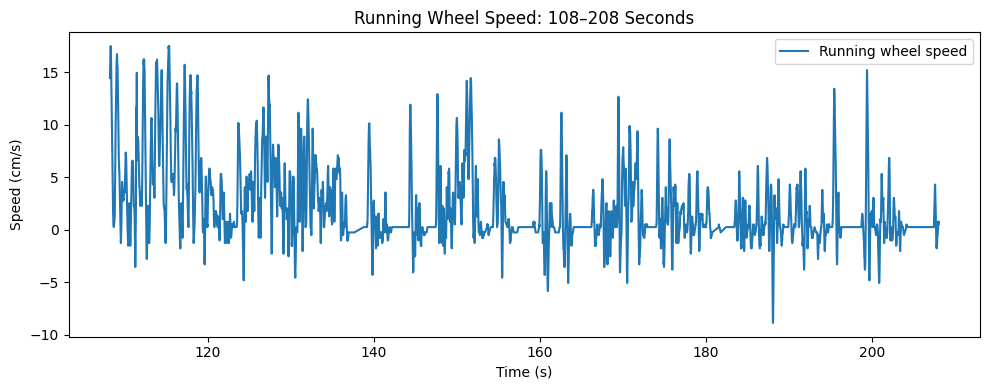

In [4]:
# Extract running wheel velocity (cm/s) for the interval 108-208 seconds
running_speed = nwbfile.processing['running']['running_speed']
rs_timestamps = running_speed.timestamps[:]
rs_data = running_speed.data[:]
mask = (rs_timestamps >= 108) & (rs_timestamps <= 208)
rs_timestamps_segment = rs_timestamps[mask]
rs_data_segment = rs_data[mask]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(rs_timestamps_segment, rs_data_segment, label='Running wheel speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Running Wheel Speed: 108–208 Seconds')
plt.legend()
plt.tight_layout()
plt.show()

## 6. Visualizing Eye Tracking (Pupil Diameter Proxy)

Pupil diameter is proxied by the average of width and height from the `pupil_tracking` data, over the same segment.

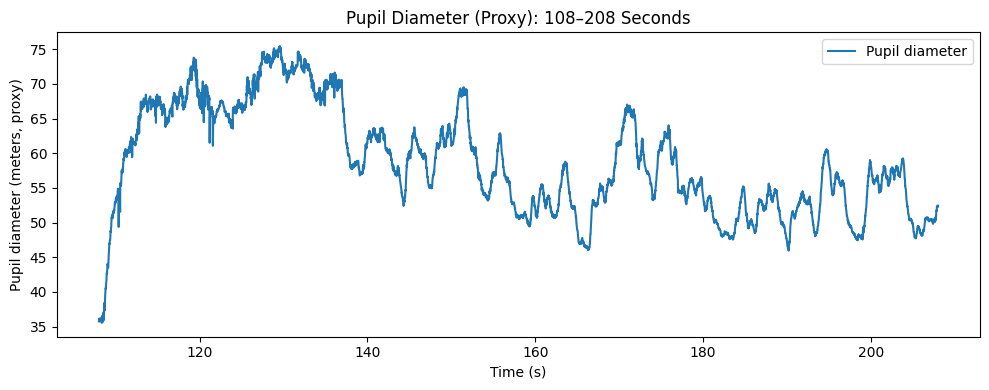

In [5]:
# Extract pupil diameter (proxy) in the 108–208s window
pupil_tracking = nwbfile.acquisition['EyeTracking'].spatial_series['pupil_tracking']
timestamps = pupil_tracking.timestamps[:]
width = pupil_tracking.width[:]
height = pupil_tracking.height[:]
pupil_diameter = (width + height) / 2
mask = (timestamps >= 108) & (timestamps <= 208)
timestamps_segment = timestamps[mask]
pupil_diameter_segment = pupil_diameter[mask]

plt.figure(figsize=(10, 4))
plt.plot(timestamps_segment, pupil_diameter_segment, label='Pupil diameter')
plt.xlabel('Time (s)')
plt.ylabel('Pupil diameter (meters, proxy)')
plt.title('Pupil Diameter (Proxy): 108–208 Seconds')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Exploring Stimulus/Event Intervals

The `intervals` module provides precise trial and presentation event timing for various stimuli and experimental epochs. Let's display all available interval group names and examine a stimulus block.

In [6]:
# List available intervals
intervals_keys = list(nwbfile.intervals.keys())
print("Available intervals:")
for k in intervals_keys:
    print("-", k)

# Examine the first few rows of one interval table (e.g., for a movie stimulus)
import pandas as pd
interval_name = "natmovie_EagleSwooping1_540x960Full_584x460Active_presentations"
interval_table = nwbfile.intervals[interval_name].to_dataframe()
interval_table.head()

Available intervals:
- Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- GreenSAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst1_loop_presentations
- SAC_Wd15_Vel2_Bndry2_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry2_Cntst0_oneway_presentations
- SAC_Wd15_Vel2_Bndry3_Cntst0_loop_presentations
- SAC_Wd15_Vel8_Bndry1_Cntst0_loop_presentations
- SAC_Wd45_Vel2_Bndry1_Cntst0_loop_presentations
- UD_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- acurl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
- curl_Wd15_Vel2_Bndry1_Cntst0_oneway_presentations
- invalid_times
- natmovie_CricketsOnARock_540x960Full_584x460Active_presentations
- natmovie_EagleSwooping1_540x960Full_584x460Active_presentations
- natmovie_EagleSwooping2_540x960Full_584x460Active_presentations
- natmovie_SnakeOnARoad_540x960Full_584x460Active_present

,start_time,stop_time,stimulus_name,stimulus_block,Image,color,contrast,opacity,orientation,size,units,stimulus_index,tags,timeseries
id,,,,,,,,,,,,,,
0,5230.53662,5230.55329,natmovie_EagleSwooping1_540x960Full_584x460Active,31.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,15.0,[stimulus_time_interval],"[(614174, 3, timestamps pynwb.base.TimeSeries ..."
1,5230.53662,5230.55329,natmovie_EagleSwooping1_540x960Full_584x460Active,31.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,15.0,[stimulus_time_interval],"[(614174, 3, timestamps pynwb.base.TimeSeries ..."
2,5230.55329,5230.56998,natmovie_EagleSwooping1_540x960Full_584x460Active,31.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,15.0,[stimulus_time_interval],"[(614177, 2, timestamps pynwb.base.TimeSeries ..."
3,5230.55329,5230.56998,natmovie_EagleSwooping1_540x960Full_584x460Active,31.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,15.0,[stimulus_time_interval],"[(614177, 2, timestamps pynwb.base.TimeSeries ..."
4,5230.56998,5230.58666,natmovie_EagleSwooping1_540x960Full_584x460Active,31.0,2.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,15.0,[stimulus_time_interval],"[(614179, 2, timestamps pynwb.base.TimeSeries ..."


## 8. Plotting Presentation Start Times for an Example Stimulus

Here, we plot the start times of the first 30 presentations of the "EagleSwooping1" movie stimulus.

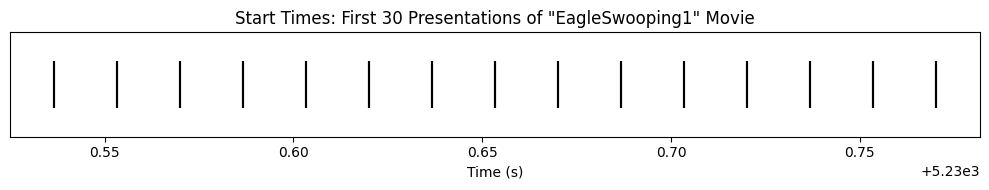

In [7]:
start_times = interval_table['start_time'][:30]

plt.figure(figsize=(10, 2))
plt.eventplot(start_times, orientation='horizontal', colors='k')
plt.xlabel('Time (s)')
plt.yticks([])
plt.title('Start Times: First 30 Presentations of "EagleSwooping1" Movie')
plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated how to list, load, and stream multi-modal data from Dandiset 000690, and how to visualize key neural and behavioral variables as well as experimental intervals.

For further exploration, consider:
- Aligning spikes or behavior to specific stimulus presentations
- Drilling deeper into other behavioral, neural, or interval data types
- Exploring other files or sessions in the Dandiset

See the [DANDI archive entry for this dataset](https://dandiarchive.org/dandiset/000690/0.250326.0015) for more details and access to data and documentation.